# Trabalho da A1 de PLI

Professora: Asla Sá

Alunos: Fernanda Luísa Silva Gomes e Igor Patrício Michels

In [1]:
using JuMP;
using GLPK;
using Plots;
using ConstraintSolver;
const CS = ConstraintSolver;

# Problema de Lógica

Em revistas e jornais é comum encontrarmos probleminhas de lógica em que temos algumas informações e precisamos descobrir o posicionamento de alguns objetos ou pessoas. Um problema de lógica que ficou muito famoso é o [Teste de Einstein](https://rachacuca.com.br/logica/problemas/teste-de-einstein/). Aqui não vamos resolver o Teste de Einstein, mas sim um problema que segue uma estrutura bem similar, o problema da [Reunião de Condomínio](https://rachacuca.com.br/logica/problemas/reuniao-de-condominio/).

Nesse problema, estamos numa reunião de condomínio e cinco condôminos estão fazendo reclamações distintas. Além disso, cada um está utilizando uma cor diferente de camisa, possui um nome diferente, idades diferentes e profissões diferentes. Com base em algumas dicas, queremos descobrir qual a posição de cada homem, bem como sua idade, nome, cor de camisa, profissão, apartamento em que mora e reclamação. Sabemos que as possibilidades para cada uma dessas variáveis são:

| Cor da camiseta | Nome    | Apartamento | Reclamação | Idade   | Profissão    |
| --------------- | ------- | ----------- | ---------- | ------- | ------------ |
| Amarela         | Antônio | 15          | Barulho    | 30 anos | Arquiteto    |
| Azul            | César   | 32          | Garagem    | 35 anos | Comerciante  |
| Branca          | Juan    | 61          | Limpeza    | 40 anos | Farmacêutico |
| Verde           | Rodolfo | 94          | Manutenção | 45 anos | Joalheiro    |
| Vermelha        | Vicente | 123         | Segurança  | 50 anos | Produtor     |

Além disso, temos as seguintes informações:

- O Comerciante está ao lado do morador que está cobrando mais Manutenção no condomínio.
- O morador de Verde está reclamando da Limpeza do prédio.
- O Joalheiro está exatamente à esquerda do condômino de 45 anos.
- César está exatamente à esquerda de quem está reclamando de Barulho.
- O Farmacêutico mora no apartamento 94.
- O homem de Verde está em algum lugar entre o homem de 35 anos e o homem de Vermelho, nessa ordem.
- O Arquiteto está ao lado do condômino que reclama do Barulho no prédio.
- Antônio está na quinta posição.
- O Comerciante está ao lado do homem mais velho.
- O morador de Branco está exatamente à direita do morador que reclama da Manutenção.
- O Joalheiro tem 40 anos.
- O condômino de camiseta Azul está ao lado do morador do apartamento 61.
- O Arquiteto está exatamente à direita de quem está reclamando da Garagem.
- Em uma das pontas está o morador do apartamento 123.
- Juan está exatamente à direita do Joalheiro.
- O morador de Azul está exatamente à esquerda de quem está reclamando da Manutenção.
- O condômino do apartamento 32 está exatamente à esquerda do Comerciante.
- O homem mais novo está em algum lugar à direita do morador de Azul.
- Vicente está em algum lugar entre o Rodolfo e o Juan, nessa ordem.
- O condômino mais velho está exatamente à esquerda do Farmacêutico.

In [2]:
function logic_test(restrictions::Vector{Bool} = [true for i in 1:20])
    model = Model(GLPK.Optimizer);
    @variable(model, decisions[1:6, 1:5, 1:5], base_name = "x", Bin);
    
    # para cada característica
    for i in 1:6
        # variando a pessoa ou o valor da característica
        for j in 1:5
            # a soma deve ser 1
            @constraint(model, sum(decisions[i, j, k] for k in 1:5) == 1);
            @constraint(model, sum(decisions[i, k, j] for k in 1:5) == 1);
        end
    end

    if restrictions[1]
        # O Comerciante está ao lado do morador que está cobrando mais Manutenção no condomínio.
        @constraint(model, decisions[6, 1, 2] <= decisions[4, 2, 4]);
        for i in 2:4
            @constraint(model, decisions[6, i, 2] <= decisions[4, i - 1, 4] + decisions[4, i + 1, 4]);
        end
        @constraint(model, decisions[6, 5, 2] <= decisions[4, 4, 4]);
    end
    
    if restrictions[2]
        # O morador de Verde está reclamando da Limpeza do prédio.
        for i in 1:5
            @constraint(model, decisions[1, i, 4] == decisions[4, i, 3]);
        end
    end
    
    if restrictions[3]
        # O Joalheiro está exatamente à esquerda do condômino de 45 anos.
        for i in 1:4
            @constraint(model, decisions[6, i, 4] == decisions[5, i + 1, 4]);
        end
        @constraint(model, decisions[6, 5, 4] == 0);
    end
    
    if restrictions[4]
        # César está exatamente à esquerda de quem está reclamando de Barulho.
        for i in 1:4
            @constraint(model, decisions[2, i, 2] == decisions[4, i + 1, 1]);
        end
        @constraint(model, decisions[2, 5, 2] == 0);
    end
    
    if restrictions[5]
        # O Farmacêutico mora no apartamento 94.
        for i in 1:5
            @constraint(model, decisions[6, i, 3] == decisions[3, i, 4]);
        end
    end
    
    if restrictions[6]
        # O homem de Verde está em algum lugar entre o homem de 35 anos e o homem de Vermelho, nessa ordem.
        @constraint(model, decisions[1, 1, 4] == 0); # O de verde não pode ser
        @constraint(model, decisions[1, 5, 4] == 0); # o primeiro nem o último
        @constraint(model, decisions[5, 4, 2] == 0); # O de 35 anos não pode ser
        @constraint(model, decisions[5, 5, 2] == 0); # o quarto nem o quinto
        @constraint(model, decisions[1, 1, 5] == 0); # O de vermelho não pode ser o
        @constraint(model, decisions[1, 2, 5] == 0); # primeiro nem o segundo
        @constraint(model, decisions[5, 1, 2] + decisions[1, 5, 5] >= sum(decisions[1, i, 4] for i in 2:4) - 1);
        @constraint(model, decisions[5, 1, 2] + decisions[1, 4, 5] >= decisions[1, 2, 4] + decisions[1, 3, 4] - 1);
        @constraint(model, decisions[5, 1, 2] + decisions[1, 3, 5] >= decisions[1, 2, 4]);
        @constraint(model, decisions[5, 2, 2] + decisions[1, 5, 5] >= decisions[1, 3, 4] + decisions[1, 4, 4] - 1);
        @constraint(model, decisions[5, 2, 2] + decisions[1, 4, 5] >= decisions[1, 3, 4] - 1);
        @constraint(model, decisions[5, 3, 2] + decisions[1, 5, 5] >= decisions[1, 4, 4]);
        for i in 1:5
            @constraint(model, decisions[1, i, 4] + decisions[5, i, 2] + decisions[1, i, 5] <= 1);
        end
    end
    
    if restrictions[7]
        # O Arquiteto está ao lado do condômino que reclama do Barulho no prédio.
        @constraint(model, decisions[6, 1, 1] <= decisions[4, 2, 1]);
        for i in 2:4
            @constraint(model, decisions[6, i, 1] <= decisions[4, i - 1, 1] + decisions[4, i + 1, 1]);
        end
        @constraint(model, decisions[6, 5, 1] <= decisions[4, 4, 1]);
    end
    
    if restrictions[8]
        # Antônio está na quinta posição.
        @constraint(model, decisions[2, 5, 1] == 1);
    end
    
    if restrictions[9]
        # O Comerciante está ao lado do homem mais velho.
        @constraint(model, decisions[6, 1, 2] <= decisions[5, 2, 5]);
        for i in 2:4
            @constraint(model, decisions[6, i, 2] <= decisions[5, i - 1, 5] + decisions[5, i + 1, 5]);
        end
        @constraint(model, decisions[6, 5, 2] <= decisions[5, 4, 5]);
    end
    
    if restrictions[10]
        # O morador de Branco está exatamente à direita do morador que reclama da Manutenção.
        for i in 1:4
            @constraint(model, decisions[1, i + 1, 3] == decisions[4, i, 4]);
        end
        @constraint(model, decisions[1, 1, 3] == 0);
    end
    
    if restrictions[11]
        # O Joalheiro tem 40 anos.
        for i in 1:5
            @constraint(model, decisions[6, i, 4] == decisions[5, i, 3]);
        end
    end
    
    if restrictions[12]
        # O condômino de camiseta Azul está ao lado do morador do apartamento 61.
        @constraint(model, decisions[1, 1, 2] <= decisions[3, 2, 3]);
        for i in 2:4
            @constraint(model, decisions[1, i, 2] <= decisions[3, i - 1, 3] + decisions[3, i + 1, 3]);
        end
        @constraint(model, decisions[1, 5, 2] <= decisions[3, 4, 3]);
    end
    
    if restrictions[13]
        # O Arquiteto está exatamente à direita de quem está reclamando da Garagem.
        for i in 1:4
            @constraint(model, decisions[6, i + 1, 1] == decisions[4, i, 2]);
        end
        @constraint(model, decisions[6, 1, 1] == 0);
    end
    
    if restrictions[14]
        # Em uma das pontas está o morador do apartamento 123.
        @constraint(model, decisions[3, 1, 5] + decisions[3, 5, 5] == 1);
    end
    
    if restrictions[15]
        # Juan está exatamente à direita do Joalheiro.
        for i in 1:4
            @constraint(model, decisions[2, i + 1, 3] == decisions[6, i, 4]);
        end
        @constraint(model, decisions[2, 1, 3] == 0);
    end
    
    if restrictions[16]
        # O morador de Azul está exatamente à esquerda de quem está reclamando da Manutenção.
        for i in 1:4
            @constraint(model, decisions[1, i, 2] == decisions[4, i + 1, 4]);
        end
        @constraint(model, decisions[1, 5, 2] == 0);
    end
    
    if restrictions[17]
        # O condômino do apartamento 32 está exatamente à esquerda do Comerciante.
        for i in 1:4
            @constraint(model, decisions[3, i, 2] == decisions[6, i + 1, 2]);
        end
        @constraint(model, decisions[3, 5, 2] == 0);
    end
    
    if restrictions[18]
        # O homem mais novo está em algum lugar à direita do morador de Azul.
        @constraint(model, decisions[1, 5, 2] == 0); # o cara de azul não pode ser o último
        @constraint(model, decisions[5, 1, 1] == 0); # e o mais novo não pode ser o primeiro
        @constraint(model, decisions[1, 1, 2] >= sum(decisions[5, i, 1] for i in 2:5) - 1);
        @constraint(model, decisions[1, 2, 2] >= sum(decisions[5, i, 1] for i in 3:5) - 1);
        @constraint(model, decisions[1, 3, 2] >= sum(decisions[5, i, 1] for i in 4:5) - 1);
        @constraint(model, decisions[1, 4, 2] >= decisions[5, 5, 1] - 1);
        @constraint(model, decisions[1, 3, 2] + decisions[5, 2, 1] <= 1);
        @constraint(model, decisions[1, 4, 2] + decisions[5, 2, 1] <= 1);
        @constraint(model, decisions[1, 4, 2] + decisions[5, 3, 1] <= 1);

        for i in 1:5
            @constraint(model, decisions[1, i, 2] + decisions[5, i, 1] <= 1);
        end
    end
    
    if restrictions[19]
        # Vicente está em algum lugar entre o Rodolfo e o Juan, nessa ordem.
        @constraint(model, decisions[2, 1, 5] == 0); # Vicente não pode ser
        @constraint(model, decisions[2, 5, 5] == 0); # o primeiro nem o último
        @constraint(model, decisions[2, 4, 4] == 0); # Rodolfo não pode ser
        @constraint(model, decisions[2, 5, 4] == 0); # o quarto nem o quinto
        @constraint(model, decisions[2, 1, 3] == 0); # Juan não pode ser o
        @constraint(model, decisions[2, 2, 3] == 0); # primeiro nem o segundo
        @constraint(model, decisions[2, 1, 4] + decisions[2, 5, 3] >= sum(decisions[2, i, 5] for i in 2:4) - 1);
        @constraint(model, decisions[2, 1, 4] + decisions[2, 4, 3] >= decisions[2, 2, 5] + decisions[2, 3, 5] - 1);
        @constraint(model, decisions[2, 1, 4] + decisions[2, 3, 3] >= decisions[2, 2, 5]);
        @constraint(model, decisions[2, 2, 4] + decisions[2, 5, 3] >= decisions[2, 3, 5] + decisions[2, 4, 5] - 1);
        @constraint(model, decisions[2, 2, 4] + decisions[2, 4, 3] >= decisions[2, 3, 5] - 1);
        @constraint(model, decisions[2, 3, 4] + decisions[2, 5, 3] >= decisions[2, 4, 5]);
    end
    
    if restrictions[20]
        # O condômino mais velho está exatamente à esquerda do Farmacêutico.
        for i in 1:4
            @constraint(model, decisions[5, i, 5] == decisions[6, i + 1, 3]);
        end
        @constraint(model, decisions[5, 5, 5] == 0);
    end
    
    optimize!(model);
    return JuMP.value.(decisions);
end;

Dentro da matriz `decisions`, a primeira dimensão se refere as características (cor da camiseta, nome, apartamento, reclamação, idade e profissão, nessa ordem), a segunda dimensão ao morador (1 a 5, nessa ordem) e a última se refere as opções de cada uma das características, na ordem da tabela anterior.

Feita a modelagem, criamos o vetor abaixo pensando em duas coisas:
- realizar a conferência do problema e;
- apresentar o resultado de uma forma um pouco mais elegante do ponto de vista visual (a professora ama visualização, certo?).

In [3]:
all_restrictions = [["O Comerciante está ao lado do morador que está cobrando mais Manutenção no condomínio.",
                     [["Comerciante", "Manutenção", [-1, 1]]]],
                    ["O morador de Verde está reclamando da Limpeza do prédio.",
                     [["Verde", "Limpeza", 0:0]]],
                    ["O Joalheiro está exatamente à esquerda do condômino de 45 anos.",
                     [["Joalheiro", "45 anos", 1:1]]],
                    ["César está exatamente à esquerda de quem está reclamando de Barulho.",
                     [["César", "Barulho", 1:1]]],
                    ["O Farmacêutico mora no apartamento 94.",
                     [["Farmacêutico", "94", 0:0]]],
                    ["O homem de Verde está em algum lugar entre o homem de 35 anos e o homem de Vermelho, nessa ordem.",
                     [["35 anos", "Verde", 1:3], ["Verde", "Vermelha", 1:3]]],
                    ["O Arquiteto está ao lado do condômino que reclama do Barulho no prédio.",
                     [["Arquiteto", "Barulho", [-1, 1]]]],
                    ["Antônio está na quinta posição.",
                     [["Antônio", "Morador 5", 0:0]]],
                    ["O Comerciante está ao lado do homem mais velho.",
                     [["Comerciante", "50 anos", [-1, 1]]]],
                    ["O morador de Branco está exatamente à direita do morador que reclama da Manutenção.",
                     [["Branca", "Manutenção", (-1):(-1)]]],
                    ["O Joalheiro tem 40 anos.",
                     [["Joalheiro", "40 anos", 0:0]]],
                    ["O condômino de camiseta Azul está ao lado do morador do apartamento 61.",
                     [["Azul", "61", [-1, 1]]]],
                    ["O Arquiteto está exatamente à direita de quem está reclamando da Garagem.",
                     [["Arquiteto", "Garagem", (-1):(-1)]]],
                    ["Em uma das pontas está o morador do apartamento 123.",
                     [["123", "Morador 3", [-2, 2]]]],
                    ["Juan está exatamente à direita do Joalheiro.",
                     [["Juan", "Joalheiro", (-1):(-1)]]],
                    ["O morador de Azul está exatamente à esquerda de quem está reclamando da Manutenção.",
                     [["Azul", "Manutenção", 1:1]]],
                    ["O condômino do apartamento 32 está exatamente à esquerda do Comerciante.",
                     [["32", "Comerciante", 1:1]]],
                    ["O homem mais novo está em algum lugar à direita do morador de Azul.",
                     [["30 anos", "Azul", (-4):(-1)]]],
                    ["Vicente está em algum lugar entre o Rodolfo e o Juan, nessa ordem.",
                     [["Rodolfo", "Vicente", 1:3], ["Vicente", "Juan", 1:3]]],
                    ["O condômino mais velho está exatamente à esquerda do Farmacêutico.",
                     [["50 anos", "Farmacêutico", 1:1]]]];

Também criamos algumas funções para realizar, junto com o vetor acima, a conferência e impressão do resultado.

In [4]:
function print_solution(solution)
    lines = [];
    header = "| Característica  |";
    sep    = "| --------------- |";
    for i in 1:5
        header *= " Morador " * string(i) * "       |" ;
        sep *= " --------------- |";
    end
    push!(lines, header);
    push!(lines, sep);
    
    caracteristicas = ["| Cor da camiseta |", "| Nome            |", "| Apartamento     |",
                       "| Reclamação      |", "| Idade           |", "| Profissão       |"];
    
    cores           = [ " Amarela         |",  " Azul            |",  " Branca          |",
                        " Verde           |",  " Vermelha        |"];
    
    nomes           = [ " Antônio         |",  " César           |",  " Juan            |",
                        " Rodolfo         |",  " Vicente         |"];
    
    apartamentos    = [ " 15              |",  " 32              |",  " 61              |",
                        " 94              |",  " 123             |"];
    
    reclamacoes     = [ " Barulho         |",  " Garagem         |",  " Limpeza         |",
                        " Manutenção      |",  " Segurança       |"];
    
    idades          = [ " 30 anos         |",  " 35 anos         |",  " 40 anos         |",
                        " 45 anos         |",  " 50 anos         |"];
    
    profissoes      = [ " Arquiteto       |",  " Comerciante     |",  " Farmacêutico    |",
                        " Joalheiro       |",  " Produtor        |"];
    
    println(header);
    println(sep);
    dados = [cores, nomes, apartamentos, reclamacoes, idades, profissoes];
    for i in 1:6
        line = caracteristicas[i];
        for j in 1:5
            for k in 1:5
                if solution[i, j, k] == 1
                    line *= dados[i][k];
                end
            end
        end
        println(line);
        push!(lines, line);
    end
    return lines;
end;

function find_position(solution, key)
    for line in solution
        if occursin(key, line)
            positions = findall("|", line);
            for i in 2:length(positions)
                if ~occursin(key, line[positions[i][1]:length(line)])
                    return i - 2;
                end
            end
        end
    end
end;

function relative_position(solution, key1, key2)
    a = find_position(solution, key1)[1];
    b = find_position(solution, key2)[1];
    return (b - a);
end;

function verify_solution(solution, restrictions)
    solution = print_solution(solution);
    println();
    for restriction in restrictions
        ok = true;
        for condition in restriction[2]
            if ~(relative_position(solution, condition[1], condition[2]) in condition[3])
                ok = false;
            end
        end
        if ok
            println("✅ " * restriction[1]);
        else
            println("❌ " * restriction[1]);
        end
    end
end;

Agora, vamos ver a solução do problema:

In [5]:
verify_solution(logic_test(), all_restrictions);

| Característica  | Morador 1       | Morador 2       | Morador 3       | Morador 4       | Morador 5       |
| --------------- | --------------- | --------------- | --------------- | --------------- | --------------- |
| Cor da camiseta | Amarela         | Verde           | Azul            | Vermelha        | Branca          |
| Nome            | Rodolfo         | Vicente         | Juan            | César           | Antônio         |
| Apartamento     | 123             | 32              | 15              | 61              | 94              |
| Reclamação      | Segurança       | Limpeza         | Garagem         | Manutenção      | Barulho         |
| Idade           | 35 anos         | 40 anos         | 45 anos         | 50 anos         | 30 anos         |
| Profissão       | Produtor        | Joalheiro       | Comerciante     | Arquiteto       | Farmacêutico    |

✅ O Comerciante está ao lado do morador que está cobrando mais Manutenção no condomínio.
✅ O morador de Verde está recl

Como podemos ver, todas as tags foram marcadas com o certinho, ou seja, todas as restrições estão sendo satisfeitas.

Por fim, também podemos relaxar algumas das restrições, gerando um novo problema, mas dessa vez com mais de uma solução.

In [6]:
restrictions = rand(Bool, length(all_restrictions));
verify_solution(logic_test(restrictions), all_restrictions[restrictions]);

| Característica  | Morador 1       | Morador 2       | Morador 3       | Morador 4       | Morador 5       |
| --------------- | --------------- | --------------- | --------------- | --------------- | --------------- |
| Cor da camiseta | Amarela         | Azul            | Verde           | Branca          | Vermelha        |
| Nome            | César           | Juan            | Rodolfo         | Vicente         | Antônio         |
| Apartamento     | 123             | 15              | 61              | 32              | 94              |
| Reclamação      | Garagem         | Barulho         | Manutenção      | Limpeza         | Segurança       |
| Idade           | 50 anos         | 35 anos         | 30 anos         | 40 anos         | 45 anos         |
| Profissão       | Arquiteto       | Comerciante     | Joalheiro       | Produtor        | Farmacêutico    |

✅ César está exatamente à esquerda de quem está reclamando de Barulho.
✅ O Farmacêutico mora no apartamento 94.
✅ O hom

# Tents

Agora, vamos resolver o jogo Tents, o qual pode ser visto [aqui](https://www.puzzle-tents.com). Nele começamos com um tabuleiro com algumas árvores e algumas restrições sobre a quantidade de barracas que devem ser alocadas em cada linha e em cada coluna. Além disso, devemos satisfazer duas restrições:
 - as barracas devem ser alocadas ao redor das árvores (em cima, embaixo, à esquerda ou à direita), de modo que haja uma relação de 1 para 1 (cada árvore tenha uma barraca e cada barraca tenha uma árvore) e;
 - duas barracas não podem ser vizinhas, nem mesmo diagonalmente.

Dito isso, vamos definir uma função para encontrar a solução dado um tabuleiro.

In [7]:
function solve_tents(T, R, C)
    n_row = size(R)[1];
    n_col = size(C)[1];
    game = Model(GLPK.Optimizer);
    @variable(game, board[1:n_row, 1:n_col, 1:2], Bin);
    
    # posicionando as árvores
    for i  in 1:n_row
        for j in 1:n_row
            # impedindo que uma barraca esteja na mesma posição de uma árvore
            @constraint(game, board[i, j, 1] + board[i, j, 2] <= 1)
            
            if [i, j] in T
                @constraint(game, board[i, j, 2] == 1)
            else
                @constraint(game, board[i, j, 2] == 0)
            end
        end
    end
    
    for i in 1:n_row
        # restringindo a quantidade de barracas numa linha
        @constraint(game, sum(board[i, j, 1] for j in 1:n_col) == R[i]);
    end

    for j in 1:n_col
        # restringindo a quantidade de barracas numa coluna
        @constraint(game, sum(board[i, j, 1] for i in 1:n_row) == C[j]);
    end
    
    for i in 1:n_row
        for j in 1:n_col
            # duas barracas não podem ser vizinhas
            @constraint(game, sum(if k == 0 && l == 0 4 * board[i, j, 1]
                                  else board[i + k, j + l, 1] end
                                      for k in [-1, 0, 1],
                                          l in [-1, 0, 1]
                                          if i + k in 1:n_row &&
                                             j + l in 1:n_col) <= 4);
            
            # ao redor de cada barraca deve ter pelo menos uma árvore
            @constraint(game, sum(board[i + k, j + l, 2]
                                  for k in [-1, 0, 1],
                                      l in [-1, 0, 1]
                                      if abs(k) + abs(l) == 1 &&
                                         i + k in 1:n_row &&
                                         j + l in 1:n_col) >= board[i, j, 1]);
            
            # ao redor de cada árvore deve ter pelo menos uma barraca
            @constraint(game, sum(board[i + k, j + l, 1]
                                  for k in [-1, 0, 1],
                                      l in [-1, 0, 1]
                                      if abs(k) + abs(l) == 1 &&
                                         i + k in 1:n_row &&
                                         j + l in 1:n_col) >= board[i, j, 2]);
        end
    end
    
    optimize!(game);
    return JuMP.value.(board);
end;

Seguindo a linha do problema anterior, vamos também elaborar uma função para fazer um print, bonitinho, do resultado.

In [8]:
function print_solution(solution)
    n_row, n_col = size(solution);
    for i in 1:n_row
        line = "";
        for j in 1:n_col
            if solution[i, j, 2] == 1
                line *= ['🌲', '🌳', '🌴'][rand(1:3)];
            elseif solution[i, j, 1] == 1
                line *= '⛺';
            else
                line *= '⬜';
            end
        end
        println(line);
    end
end;

Agora, vamos colocar a função para rodar:

In [9]:
T = [[2, 5], [3, 1], [3, 5], [4, 4],
     [5, 3], [6, 2], [6, 5]]; # árvores

R = [1, 1, 0, 2, 0, 3]; # linhas
C = [2, 0, 2, 0, 2, 1]; # colunas
print_solution(solve_tents(T, R, C));

⬜⬜⬜⬜⛺⬜
⛺⬜⬜⬜🌴⬜
🌲⬜⬜⬜🌴⬜
⬜⬜⛺🌳⛺⬜
⬜⬜🌴⬜⬜⬜
⛺🌲⛺⬜🌳⛺


In [10]:
T = [[1, 3], [1, 8], [2, 1], [2, 4], [3, 2], [3, 5],
     [5, 2], [5, 4], [5, 8], [6, 4], [7, 6], [8, 2]]; # árvores

R = [3, 0, 2, 2, 1, 1, 2, 1]; # linhas
C = [2, 2, 0, 3, 1, 1, 2, 1]; # colunas
print_solution(solve_tents(T, R, C));

⛺⬜🌲⛺⬜⬜⛺🌴
🌲⬜⬜🌲⬜⬜⬜⬜
⬜🌳⬜⛺🌳⛺⬜⬜
⬜⛺⬜⬜⬜⬜⬜⛺
⬜🌳⬜🌳⛺⬜⬜🌴
⬜⛺⬜🌴⬜⬜⬜⬜
⬜⬜⬜⛺⬜🌲⛺⬜
⛺🌲⬜⬜⬜⬜⬜⬜


In [11]:
T = [[ 1,  2], [ 1, 10], [ 1, 13], [ 2,  1], [ 2,  7], [ 2,  8], [ 2, 12], [ 2, 13], [ 3,  5],
     [ 3, 11], [ 4,  2], [ 4,  6], [ 5,  1], [ 5,  3], [ 5, 12], [ 6,  9], [ 6, 15], [ 7,  2],
     [ 7,  5], [ 7,  7], [ 7,  8], [ 7, 13], [ 8,  5], [ 8,  7], [ 8,  9], [ 8, 15], [ 9,  4],
     [ 9, 13], [10,  3], [11,  3], [11,  9], [11, 11], [11, 15], [12,  1], [12,  7], [12,  9],
     [14,  1], [14,  5], [14, 13], [15,  2], [15,  6], [15,  7], [15, 11], [15, 13], [15, 14]]; # árvores

R = [5, 2, 1, 5, 2, 4, 2, 4, 2, 3, 2, 3, 3, 1, 6]; # linhas
C = [5, 1, 5, 2, 4, 2, 4, 2, 2, 4, 1, 5, 2, 2, 4]; # colunas
print_solution(solve_tents(T, R, C));

⛺🌲⛺⬜⬜⬜⬜⛺⬜🌳⬜⛺🌴⛺⬜
🌴⬜⬜⬜⬜⛺🌴🌳⬜⛺⬜🌴🌲⬜⬜
⬜⬜⬜⬜🌴⬜⬜⬜⬜⬜🌴⬜⛺⬜⬜
⛺🌲⛺⬜⛺🌲⛺⬜⬜⬜⛺⬜⬜⬜⬜
🌴⬜🌴⬜⬜⬜⬜⬜⛺⬜⬜🌳⬜⬜⛺
⬜⬜⛺⬜⛺⬜⛺⬜🌲⬜⬜⛺⬜⬜🌳
⛺🌳⬜⬜🌲⬜🌲🌲⬜⬜⬜⬜🌲⛺⬜
⬜⬜⬜⛺🌳⛺🌴⛺🌲⛺⬜⬜⬜⬜🌴
⬜⬜⬜🌳⬜⬜⬜⬜⬜⬜⬜⛺🌴⬜⛺
⬜⛺🌳⛺⬜⬜⬜⬜⛺⬜⬜⬜⬜⬜⬜
⬜⬜🌳⬜⬜⬜⛺⬜🌳⬜🌴⛺⬜⬜🌳
🌳⬜⛺⬜⬜⬜🌴⬜🌲⛺⬜⬜⬜⬜⛺
⛺⬜⬜⬜⛺⬜⬜⬜⬜⬜⬜⬜⛺⬜⬜
🌳⬜⬜⬜🌲⬜⛺⬜⬜⬜⬜⬜🌴⬜⬜
⛺🌲⛺⬜⛺🌳🌲⬜⬜⛺🌴⛺🌴🌴⛺


# Two + two = four

Um outro problema que pode ser modelado linearmente é o de quebra-cabeças alfanuméricos, onde temos uma expressão dada pela soma de duas ou mais palavras e um resultado também dado por uma palavra. Nesse quebra-cabeça queremos encontrar algarismos que satisfazem essa expressão de modo que:
- não haja nenhum zero à esquerda;
- cada letra tem um valor (algarismo) fixo;
- letras diferentes representam algarismos diferentes.

Para esse problema, elaboramos uma solução usando o GLPK e uma com o ConstraintSolver.

Abaixo a solução via GLPK:

In [12]:
sum = Model(GLPK.Optimizer);
#as letras devem assumir um valor de 1 a 9, tomando o cuidado de não ter zeros à esquerda
@variable(sum, 1 <= T <= 9, Int);
@variable(sum, 0 <= W <= 9, Int);
@variable(sum, 0 <= O <= 9, Int);
@variable(sum, 1 <= F <= 9, Int);
@variable(sum, 0 <= U <= 9, Int);
@variable(sum, 0 <= R <= 9, Int);

#a variável C_1 é 1 se a soma dos algarismos que ocupam a casa das unidades é maior ou igual a 10
@variable(sum, C1, Bin);
#a variável C_2 é 1 se a soma dos algarismos que ocupam a casa das dezenas é maior ou igual a 10
@variable(sum, C2, Bin);
#a variável C_3 é 1 se a soma dos algarismos que ocupam a casa das centenas é maior ou igual a 10
@variable(sum, C3, Bin);

#a variável ab é 1 se a é maior que b
@variable(sum, tw, Bin);
@variable(sum, to, Bin);
@variable(sum, tf, Bin);
@variable(sum, tu, Bin);
@variable(sum, tr, Bin);
@variable(sum, wo, Bin);
@variable(sum, wf, Bin);
@variable(sum, wu, Bin);
@variable(sum, wr, Bin);
@variable(sum, of, Bin);
@variable(sum, ou, Bin);
@variable(sum, or, Bin);
@variable(sum, fu, Bin);
@variable(sum, fr, Bin);
@variable(sum, ur, Bin);

#restrições de modo que letras diferentes representem algarismos diferentes
@constraint(sum, T - W >= - 11 * (1 - tw) + 1);
@constraint(sum, W - T >= - 11 * (tw) + 1);
@constraint(sum, T - O >= - 11 * (1 - to) + 1);
@constraint(sum, O - T >= - 11 * (to) + 1);
@constraint(sum, T - F >= - 11 * (1 - tf) + 1);
@constraint(sum, F - T >= - 11 * (tf) + 1);
@constraint(sum, T - U >= - 11 * (1 - tu) + 1);
@constraint(sum, U - T >= - 11 * (tu) + 1);
@constraint(sum, T - R >= - 11 * (1 - tr) + 1);
@constraint(sum, R - T >= - 11 * (tr) + 1);

@constraint(sum, W - O >= - 11 * (1 - wo) + 1);
@constraint(sum, O - W >= - 11 * (wo) + 1);
@constraint(sum, W - F >= - 11 * (1 - wf) + 1);
@constraint(sum, F - W >= - 11 * (wf) + 1);
@constraint(sum, W - U >= - 11 * (1 - wu) + 1);
@constraint(sum, U - W >= - 11 * (wu) + 1);
@constraint(sum, W - R >= - 11 * (1 - wr) + 1);
@constraint(sum, R - W >= - 11 * (wr) + 1);

@constraint(sum, O - F >= - 11 * (1 - of) + 1);
@constraint(sum, F - O >= - 11 * (of) + 1);
@constraint(sum, O - U >= - 11 * (1 - ou) + 1);
@constraint(sum, U - O >= - 11 * (ou) + 1);
@constraint(sum, O - R >= - 11 * (1 - or) + 1);
@constraint(sum, R - O >= - 11 * (or) + 1);

@constraint(sum, F - U >= - 11 * (1 - fu) + 1);
@constraint(sum, U - F >= - 11 * (fu) + 1);
@constraint(sum, F - R >= - 11 * (1 - fr) + 1);
@constraint(sum, R - F >= - 11 * (fr) + 1);

@constraint(sum, U - R >= - 11 * (1 - ur) + 1);
@constraint(sum, R - U >= - 11 * (ur) + 1);

#restrição sobre as somas das letras
@constraint(sum, 2 * O == R + 10 * C1);
@constraint(sum, 2 * W + C1 == U + 10 * C2);
@constraint(sum, 2 * T + C2 == O + 10 * C3);
@constraint(sum, C3 == F);

optimize!(sum);
T = Int(JuMP.value.(T));
W = Int(JuMP.value.(W));
O = Int(JuMP.value.(O));
F = Int(JuMP.value.(F));
U = Int(JuMP.value.(U));
R = Int(JuMP.value.(R));

println("$T$W$O + $T$W$O = $F$O$U$R");

734 + 734 = 1468


Note que muitas das restrições acima se fazem necessárias para garantir que duas letras distintas não sejam dadas pelo mesmo algarismo. Pensando nisso, podemos usar o ConstraintSolver, com o método `AllDifferentSet`, que realiza todas essas restrições em uma linha.

Abaixo a solução com o uso desse solver:

In [13]:
sum = Model(CS.Optimizer);
#as letras devem assumir um valor de 1 a 9, tomando o cuidado de não ter zeros à esquerda
@variable(sum, 1 <= T <= 9, Int);
@variable(sum, 0 <= W <= 9, Int);
@variable(sum, 0 <= O <= 9, Int);
@variable(sum, 1 <= F <= 9, Int);
@variable(sum, 0 <= U <= 9, Int);
@variable(sum, 0 <= R <= 9, Int);

#a variável C_1 é 1 se a soma dos algarismos que ocupam a casa das unidades é maior ou igual a 10
@variable(sum, C1, Bin);
#a variável C_2 é 1 se a soma dos algarismos que ocupam a casa das dezenas é maior ou igual a 10
@variable(sum, C2, Bin);
#a variável C_3 é 1 se a soma dos algarismos que ocupam a casa das centenas é maior ou igual a 10
@variable(sum, C3, Bin);

#letras diferentes devem representar algarismos diferentes
@constraint(sum, [T, W, O, F, U, R] in CS.AllDifferentSet())

#restrição sobre as somas das letras
@constraint(sum, 2 * O == R + 10 * C1);
@constraint(sum, 2 * W + C1 == U + 10 * C2);
@constraint(sum, 2 * T + C2 == O + 10 * C3);
@constraint(sum, C3 == F);

optimize!(sum);
T = Int(JuMP.value.(T));
W = Int(JuMP.value.(W));
O = Int(JuMP.value.(O));
F = Int(JuMP.value.(F));
U = Int(JuMP.value.(U));
R = Int(JuMP.value.(R));

println("$T$W$O + $T$W$O = $F$O$U$R")

# Variables: 9
# Constraints: 5
 - # Equality: 4
 - # Alldifferent: 1

  #Open    #Closed       Incumbent           Best Bound      Time [s] 
    2         0              -              0.0000000000       3.46   
    2         4         0.0000000000        0.0000000000       4.29   
734 + 734 = 1468


# Problema das damas

O problema das $8$ rainhas (ou damas, no linguajar enxadrístico) é um problema em que devemos dispor $8$ damas em um tabuleiro padrão de xadrez ($8$x$8$) sem que duas damas se ataquem. O problema é clássico e pode ser extendido para um tabuleiro $n$ x $n$, devendo, portanto dispor $n$ damas nesse tabuleiro de modo que nenhum par se ataque mutuamente.

Para $n = 1$, a solução é trivial, enquanto para $n = 2$ e $n = 3$ não existe solução. Nesse caso, iremos focar no problema com $n\geq 4$. Aqui, vamos elaborar uma função que, dado um $n$ imprima uma solução para o problema. Para tanto, vamos elaborar, primeiramente, uma função que, dada a solução, imprime o tabuleiro resultante.

In [14]:
function print_solution(solution)
    n = size(solution)[1];
    for i in 1:n
        line = "";
        for j in 1:n
            if solution[i, j] == 1
                line *= '👑';
            else
                line *= '⬜';
            end
        end
        println(line);
    end
end;

Elaborada tal função, podemos criar uma função para resolver o problema das $n$ damas.

In [15]:
function n_queens_solve(n::Int64 = 0, printing::Bool = true)
    board = Model(GLPK.Optimizer);
    if n == 0
        println("Qual o valor de n?");
        n = parse(Int64, readline());
    end

    @variable(board, B[1:n, 1:n], Bin);

    # restrições horizontais e verticais
    for i in 1:n
        # soma das linhas deve ser 1 (ter só uma dama)
        @constraint(board, sum(B[i, j] for j in 1:n) == 1);

        # soma das colunas deve ser 1 (ter só uma dama)
        @constraint(board, sum(B[j, i] for j in 1:n) == 1);
    end

    # restrições diagonais
    for k in 2:2*n
        # passando por todas as diagonais (superior esquerdo para inferior direito)
        # de tamanho k as quais podem ter, no máximo, uma dama
        @constraint(board, sum(B[i, j] for i in 1:n, j in 1:n if i + j == k) <= 1);

        # passando por todas as diagonais (superior direito para inferior esquerdo)
        # de tamanho k - n - 1 as quais podem ter, no máximo, uma dama
        @constraint(board, sum(B[i, j] for i in 1:n, j in 1:n if i - j == k - n - 1) <= 1);
    end
    
    optimize!(board);
    if printing
        print_solution(JuMP.value.(B));
    end
end;

Por fim, podemos aplicar a função:

In [16]:
n_queens_solve(8)

⬜⬜⬜⬜⬜👑⬜⬜
⬜⬜⬜⬜⬜⬜⬜👑
⬜👑⬜⬜⬜⬜⬜⬜
⬜⬜⬜👑⬜⬜⬜⬜
👑⬜⬜⬜⬜⬜⬜⬜
⬜⬜⬜⬜⬜⬜👑⬜
⬜⬜⬜⬜👑⬜⬜⬜
⬜⬜👑⬜⬜⬜⬜⬜


In [17]:
n_queens_solve(20)

⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜👑⬜⬜⬜⬜⬜⬜⬜⬜⬜
⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜👑⬜⬜⬜⬜⬜
⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜👑⬜
⬜⬜⬜⬜⬜👑⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜
⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜👑⬜⬜⬜⬜⬜⬜
⬜⬜⬜⬜⬜⬜⬜⬜👑⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜
⬜⬜⬜⬜⬜⬜👑⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜
⬜⬜⬜⬜👑⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜
⬜👑⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜
⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜👑⬜⬜⬜⬜
⬜⬜⬜⬜⬜⬜⬜⬜⬜👑⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜
⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜👑⬜⬜⬜
⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜👑
⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜👑⬜⬜
⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜👑⬜⬜⬜⬜⬜⬜⬜
⬜⬜⬜👑⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜
👑⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜
⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜👑⬜⬜⬜⬜⬜⬜⬜⬜
⬜⬜⬜⬜⬜⬜⬜👑⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜
⬜⬜👑⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜


Por fim, podemos analisar o tempo de execução do solver quando o número de damas aumenta. Assim, podemos fazer um loop na quantidade de damas e ir salvando essa quantidade e o tempo de execução.

In [18]:
times = [];
queens = [];
for n in 4:4:120
    append!(queens, n);
    append!(times, @elapsed n_queens_solve(n, false));
end

Por fim, podemos plotar os resultados:

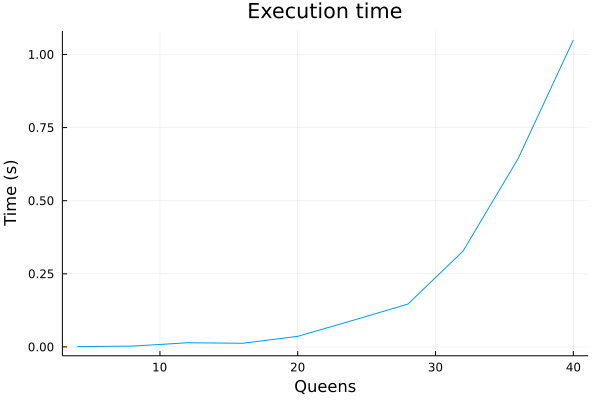

In [19]:
plot(queens[1:10], times[1:10],
     legend = false,
     title = "Execution time",
     xlabel = "Queens",
     ylabel = "Time (s)")

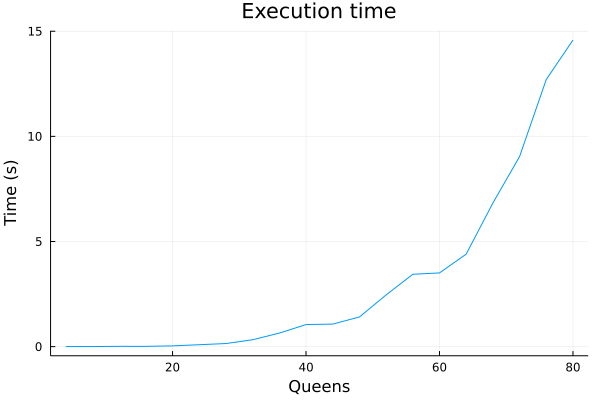

In [20]:
plot(queens[1:20], times[1:20],
     legend = false,
     title = "Execution time",
     xlabel = "Queens",
     ylabel = "Time (s)")

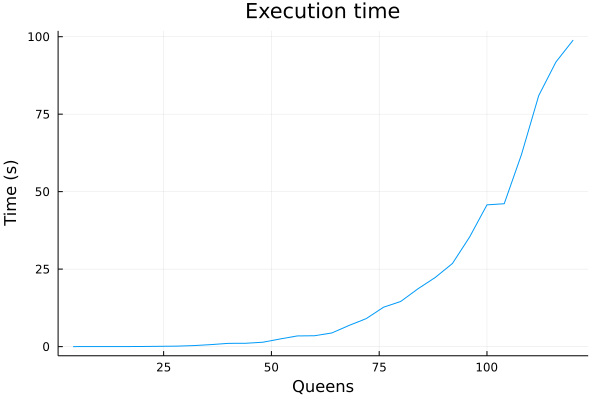

In [21]:
plot(queens, times,
     legend = false,
     title = "Execution time",
     xlabel = "Queens",
     ylabel = "Time (s)")

Conforme os gráficos acima, podemos ver que a complexidade do problema cresce rapidamente com o aumento no número de damas. 